In [23]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build

# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install category_encoders
# !pip install xgboost
# !pip install fuzzywuzzy --user
# !pip install lightgbm --user

import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

## Functions

In [3]:

def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """

    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe


def train_lr(df_train, features_cat, features_cont, target):
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
  
    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, y_train)
       
    return model, ohe

def predict_lr(df_test, model, ohe, features_cat, features_cont, target, postfix):    
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    y_pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
  
    rmse = np.sqrt(MSE(np.exp(y_test), np.exp(pred)))
    mae = MAE(np.exp(y_test), np.exp(pred))
    print("Aggergate error : % f" %(np.exp(pred).sum()-np.exp(y_test).sum()))
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae)) 
    
    return df_pred

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[list(set(['title_name', 'title_id','category','season_number', 'effective_start_date'] + features_cat + features_cont + ['first_views']))]
    df_pred['first_views_log_{}'.format(postfix)] = pred

    return df_pred



def train_lgbm(df_train, features_cat, features_cont, target, param):       
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)

    x_train = lightgbm.Dataset(x_ohe, label=y_train)
    model = lightgbm.train(param, x_train, verbose_eval = -1)

    return model, ohe


def predict_lgbm(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred.head()

    return df_pred


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
    'start_year',
#     'start_quarter',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot'
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror",
            "gamma":1}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



# Prediction

#### Get train/pred data

In [4]:
date_eval_end = '2021-09-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_1025.csv')
df_raw= df_raw.copy()
df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
df_raw['start_year'] = pd.to_datetime(df_raw['effective_start_date']).dt.year
df_raw['start_month'] = pd.to_datetime(df_raw['effective_start_date']).dt.month
df_raw['start_year_month'] = df_raw['effective_start_date'].dt.strftime('%Y-%m')
df_raw['start_quarter'] = df_raw['effective_start_date'].dt.quarter

df_raw = df_raw[(df_raw['effective_start_date']<=date_eval_end) & (df_raw.title_name!='Dune')]

grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date', 'start_year', 'start_month', 'start_year_month', 'start_quarter']
df = df_raw[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
print(df.shape)
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log(df['first_views'])


## add imdb features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered.csv')
print(df_imdb.columns)

col = ['title_id', 'asset_title_long', 'imdb_id', 'genres', 'title_type',
       'ref_follows', 'ref_remake_of', 'ref_spin_off_from', 'ref_version_of',
      'ref_ref_featured_in','ref_ref_spoofed_in']
df = df.merge(df_imdb[col], how='left', on=['title_id'])
df['ref_tot'] = df[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
df['ref_ref_tot'] = df[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)

## Clean data and make a copy for evaluation
df = df.fillna(0)
df.head(2)
print(df.shape)
print('# title: ', df.title_name.nunique())
print(df.columns)
df=df.drop_duplicates(subset=['title_id','tier','category','season_number'],keep='first')
print(df.shape)

df_actual = df.copy()

## Adjust tier feature for train & pred 
df.loc[(df['category']=='Popcorn') & (df['tier']==1), ['tier']] = 0
df.loc[(df['category']=='Popcorn') & (df['tier']==2), ['tier']] = 1

df_train = df.copy()

(317, 14)
# title:  268
(317, 14)
Index(['Unnamed: 0', 'tier', 'content_category', 'category', 'title_name',
       'title_id', 'season_number', 'program_type', 'first_views',
       'title_type', 'imdb_id', 'asset_title_long', 'genres', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_version_of',
       'ref_ref_featured_in', 'ref_ref_spoofed_in'],
      dtype='object')
(623, 27)
# title:  268
Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'start_year',
       'start_month', 'start_year_month', 'start_quarter', 'first_views',
       'premiering_hours_runtime', 'first_views_log', 'asset_title_long',
       'imdb_id', 'genres', 'title_type', 'ref_follows', 'ref_remake_of',
       'ref_spin_off_from', 'ref_version_of', 'ref_ref_featured_in',
       'ref_ref_spoofed_in', 'ref_tot', 'ref_ref_tot'],
      dtype='object')
(317, 27)


#### Train & predict

In [5]:
date_eval_end = '2021-09-01'
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']

## Get decay curve 
def get_decay_data_title(df_plt, grpby):
    df_plt = df_plt[grpby + ['days_since_premiere','first_views']].sort_values(by=grpby+['days_since_premiere'])
    df_plt['first_views_sum'] = df_plt.groupby(grpby)['first_views'].transform('sum')
    df_plt['first_views_cumsum'] = df_plt.groupby(by=grpby)['first_views'].cumsum()
    df_plt['first_views_cumpct'] = df_plt['first_views_cumsum'] / df_plt['first_views_sum']
    df_plt.reset_index(inplace=True)
    return df_plt

def get_decay_data(df_plt, grpby):
    df_plt = df_plt[grpby + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=grpby+['days_since_premiere'])
    df_plt = df_plt.groupby(by=grpby + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
    df_plt['first_views_pct'] = df_plt.groupby(grpby)['first_views_cumpct'].diff()
    df_plt = df_plt.rename(columns={'title_id':'title_count_training'})
    df_plt.reset_index(inplace=True)
    df_plt.loc[(df_plt['first_views_pct'].isnull()) & (df_plt.days_since_premiere==0),'first_views_pct'] = df_plt['first_views_cumpct']
    df_plt['days_since_premiere'] = df_plt['days_since_premiere'].astype(int)
    return df_plt

def get_agg_first_views(df_in, grpby_title, agg_col, request_date_col, first_view_col, postfix):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[request_date_col] = pd.to_datetime(df_in[request_date_col])
    df_in['first_view_quarter'] = df_in[request_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[request_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + [first_view_col]].groupby(by=grpby_title_agg).sum().reset_index()

    return df_in

def get_plot(dflist, varlist, labellist=None,  ## Old
              title=None, config={}, x_var='order_date', y_var='y_var',  mode='lines+markers'):
    ## Create dataframe x var combinations (plot all variables for each dataframe)
    dfvarlist=itertools.product(*[dflist,varlist])
        
    ## For every dataframe x variable, create a data trace for plotting
    data=[]    
    for dfvar, name in zip(dfvarlist, labellist):
        dfplt,var=dfvar[0], dfvar[1]
        data = data + [go.Scatter(x=dfplt[x_var], y=dfplt[var], mode=mode, name=name)]  

    ## Initiate offline plot and create plot
    py.offline.init_notebook_mode(connected=True) 
    layout = dict(title = title,
                  xaxis = dict(title = x_var), #, range=['2017-09-01','2017-02-01']
                  yaxis = dict(title = y_var),
                  autosize=False,
                  width=(600),
                  height=(400),
                  showlegend=True,
                 )
    fig = dict(data=data, layout=layout)
    return fig

def evaluate_pred_group(df_plt, grpby, key, pred_list):

    for quarter, group in df_plt.groupby(grpby):
        actuals_mean=group['first_views'].mean()
        actuals_sum=group['first_views'].sum()
        print('_____________________________________________________________')
        print(f'{key} {quarter} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
        for i in ['median_mx'] + list_postfix:  
            mae = MAE(group['first_views'], group[f'first_views_decay_{i}'])
            pred= group[f'first_views_decay_{i}'].sum()
            print(f'{key} {quarter} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')
    
    return



In [6]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev_b'

var_agg = 'first_view_month'
date_eval_end = '2021-09-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']

df_popcorn_decay = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/popcorn_decay_210801.csv')


for date_pred in list_date_pred:
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_data(df_decay_title, ['category'])
    df_decay_tier = get_decay_data(df_decay_title, ['tier'])

    ## Apply decay to prediction 
    df_pred_decay = df_pred.merge(df_popcorn_decay[['category','days_since_premiere','first_views_pct']], 
                                                on=['category'], how='left', suffixes=['','_popcorn'])\
                            .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier','days_since_premiere'], how='left', suffixes=['', '_tier'])\
                            .merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                                            on=['category','days_since_premiere'], how='left', suffixes=['', '_category'])

    df_pred_decay['first_views_pct_popcorn']  = df_pred_decay['first_views_pct'] 
    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct_category']
    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_popcorn'])
    df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
    df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']
    df_pred_list.append(df_pred_decay)  
    
df_pred_decay = pd.concat(df_pred_list)
display(df_pred_decay[df_pred_decay.category=='Popcorn'])

2021-01-01 86 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-02-01 105 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-03-01 122 (1, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-04-01 135 (2, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-05-01 146 (4, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-06-01 158 (5, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-07-01 168 (6, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-08-01 177 (7, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


season_number content_category               title_id         title_name  \
91               0           movies  GYA79hQZbUsI3gQEAAAB0  The Little Things   
92               0           movies  GYA79hQZbUsI3gQEAAAB0  The Little Things   
93               0           movies  GYA79hQZbUsI3gQEAAAB0  The Little Things   
94               0           movies  GYA79hQZbUsI3gQEAAAB0  The Little Things   
95               0           movies  GYA79hQZbUsI3gQEAAAB0  The Little Things   
..             ...              ...                    ...                ...   
241              0           movies  GYQBEaQwta8PCAAEAAAA-       Reminiscence   
242              0           movies  GYQBEaQwta8PCAAEAAAA-       Reminiscence   
243              0           movies  GYQBEaQwta8PCAAEAAAA-       Reminiscence   
244              0           movies  GYQBEaQwta8PCAAEAAAA-       Reminiscence   
245              0           movies  GYQBEaQwta8PCAAEAAAA-       Reminiscence   

    effective_start_date category  ref_tot  first_views  start_year  tier  \
91            2021-01-29  Popcorn      0.0       635584        2021     1   
92            2021-01-29  Popcorn      0.0       635584        2021     1   
93            2021-01-29  Popcorn      0.0       635584        2021     1   
94            2021-01-29  Popcorn      0.0       635584        2021     1   
95            2021-01-29  Popcorn      0.0       635584        2021     1   
..                   ...      ...      ...          ...         ...   ...   
241           2021-08-20  Popcorn      0.0        68705        2021     1   
242           2021-08-20  Popcorn      0.0        68705        2021     1   
243           2021-08-20  Popcorn      0.0        68705        2021     1   
244           2021-08-20  Popcorn      0.0        68705        2021     1   
245           2021-08-20  Popcorn      0.0        68705        2021     1   

    program_type  first_views_log_dev_b  first_views_dev_b  \
91      acquired             539.409546       238311.59375   
92      acquired             539.409546       238311.59375   
93      acquired             539.409546       238311.59375   
94      acquired             539.409546       238311.59375   
95      acquired             539.409546       238311.59375   
..           ...                    ...                ...   
241     acquired             580.019165       343206.96875   
242     acquired             580.019165       343206.96875   
243     acquired             580.019165       343206.96875   
244     acquired             580.019165       343206.96875   
245     acquired             580.019165       343206.96875   

     days_since_premiere  first_views_pct  first_views_pct_tier  \
91                     0         0.040576              0.041857   
92                     1         0.164951              0.057669   
93                     2         0.158119              0.048636   
94                     3         0.089434              0.080221   
95                     4         0.042489              0.046471   
..                   ...              ...                   ...   
241                   27         0.006536              0.003679   
242                   28         0.007283              0.003950   
243                   29         0.012485              0.005357   
244                   30         0.018952              0.005374   
245                   31         0.006862              0.004662   

     first_views_pct_category  first_views_pct_popcorn request_date  \
91                        NaN                 0.040576   2021-01-29   
92                        NaN                 0.164951   2021-01-30   
93                        NaN                 0.158119   2021-01-31   
94                        NaN                 0.089434   2021-02-01   
95                        NaN                 0.042489   2021-02-02   
..                        ...                      ...          ...   
241                  0.006536                 0.006536   202

## Evaluation

In [67]:
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['premiere_month'] = df_temp['premiere_date'].dt.to_period('M').dt.to_timestamp()
    df_temp = df_temp[df_temp.premiere_date.dt.strftime('%Y-%m')== datetime.strptime(date_start, '%Y-%m-%d').strftime('%Y-%m')]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)


In [8]:
# Get actuals & baseline 
agg_var = 'first_view_month'

# ## Get actuals 
grpby_title= ['title_name', 'title_id', 'season_number', 'effective_start_date', 'tier','content_category','category']
df_eval_actuals = df_raw[(df_raw.effective_start_date>='2021-01-01') & (df_raw.effective_start_date<'2021-09-01')].copy()
df_eval_actuals = get_agg_first_views(df_eval_actuals, grpby_title, agg_var,'request_date', 'first_views', 'actual')

## Get Median model baseline. pred = 1 month  
df_median_mx_raw = []
for date, date_start in zip(['210101','210201','210301','210401','210501', '210601', '210701', '210801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_new_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['premiere_date'] = pd.to_datetime(df_temp['premiere_date'])
    df_temp['premiere_month'] = df_temp['premiere_date'].dt.to_period('M').dt.to_timestamp()
    df_temp = df_temp[df_temp.premiere_date.dt.strftime('%Y-%m')== datetime.strptime(date_start, '%Y-%m-%d').strftime('%Y-%m')]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)

grpby_title= ['title_name', 'season_number']
df_title = df_median_mx_raw[grpby_title].drop_duplicates(subset=grpby_title)
df_title['title_name_match'] = df_title['title_name'].apply(lambda x: process.extractOne(x, df_eval_actuals['title_name'].to_list(), score_cutoff=90))
name_from_df2_list = df_title['title_name_match'].to_list()
name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
df_title['title_name_match'] = name_from_df2_list
df_title.loc[df_title.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
df_title.loc[df_title.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'

df_median_mx = get_agg_first_views(df_median_mx_raw, grpby_title, agg_var, 'seq_date', 'predicted_first_views', 'median_mx')
df_median_mx['first_views_decay_median_mx'] = df_median_mx['predicted_first_views'] 
df_median_mx = df_median_mx.merge(df_title[['title_name','title_name_match']], how='left', on=['title_name'])
df_median_mx['title_name_fp'] = df_median_mx['title_name']
df_median_mx['title_name'] = df_median_mx['title_name_match']

# Fill in seasons 
df_title_season = df_eval_actuals.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])
df_median_mx = df_median_mx.drop_duplicates(subset=['title_name','season_number', agg_var])


# ## Get aggregated xgb prediction 
df_pred_dev_b = get_agg_first_views(df_pred_decay, grpby_title, var_agg,'request_date', f'first_views_decay_{postfix}', postfix)

## Merge actual, median baseline and prediction 
display(df_eval_actuals.head(2))
display(df_median_mx.head(2))
display(df_pred_dev_b.head(2))
df_eval = df_eval_actuals.merge(df_median_mx, on=['title_name', 'season_number', agg_var], how='left')\
        .merge(df_pred_dev_b[['title_name','season_number',agg_var,'first_views_decay_dev_b']], on=['title_name','season_number',agg_var], how='left')
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_decay_median_mx_log'] = np.log(df_eval['first_views_decay_median_mx'])
df_eval['first_views_decay_dev_b_log'] = np.log(df_eval['first_views_decay_dev_b'])
print(df_eval.title_name.nunique())
print(df_eval.isnull().sum())
print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
print(df_eval.columns)
df_eval = df_eval.dropna()

title_name               title_id  season_number effective_start_date  \
0  100 Foot Wave  GYK6A0wdFMsMdJgEAAAAJ              1           2021-07-19   
1  100 Foot Wave  GYK6A0wdFMsMdJgEAAAAJ              1           2021-07-19   

   tier content_category     category first_view_month  first_views  
0     3           series  Docu-Series       2021-07-01         5917  
1     3           series  Docu-Series       2021-08-01         8994

title_name  season_number first_view_month  predicted_first_views  \
0  100 Foot Wave              1       2021-07-01                 4220.0   
1  100 Foot Wave              1       2021-08-01                 3160.0   

   first_views_decay_median_mx title_name_match  title_name_fp  
0                       4220.0    100 Foot Wave  100 Foot Wave  
1                       3160.0    100 Foot Wave  100 Foot Wave

title_name  season_number first_view_month  first_views_decay_dev_b
0  100 Foot Wave              1       2021-07-01              3049.619946
1  100 Foot Wave              1       2021-08-01              2870.167370

129
title_name                          0
title_id                            0
season_number                       0
effective_start_date                0
tier                                0
content_category                    0
category                            0
first_view_month                    0
first_views                         0
predicted_first_views              45
first_views_decay_median_mx        45
title_name_match                   45
title_name_fp                      45
first_views_decay_dev_b             0
first_views_log                     0
first_views_decay_median_mx_log    45
first_views_decay_dev_b_log         0
dtype: int64
13
0
Index(['title_name', 'title_id', 'season_number', 'effective_start_date',
       'tier', 'content_category', 'category', 'first_view_month',
       'first_views', 'predicted_first_views', 'first_views_decay_median_mx',
       'title_name_match', 'title_name_fp', 'first_views_decay_dev_b',
       'first_views_log', 'first_views_dec

divide by zero encountered in log


In [134]:
# ### Some rows missing due to mismatch in premiere_date. 
# ## Looks like past Pay1 titles that are coming back to the platform in the future are overwritten.
# ## The impact is pretty small 
# df_eval = df_eval_actuals.merge(df_median_mx, on=['title_name', 'season_number', 'first_view_month'], how='left')\
#         .merge(df_pred_dev_b[['title_name','season_number','first_view_month','first_views_decay_dev_b']], on=['title_name','season_number','first_view_month'], how='left')
# df_eval['first_views_log'] = np.log(df_eval['first_views'] )
# df_eval['first_views_decay_median_mx_log'] = np.log(df_eval['first_views_decay_median_mx'])
# df_eval['first_views_decay_dev_b_log'] = np.log(df_eval['first_views_decay_dev_b'])
# # display(df_eval[df_eval.title_name_match.isnull()].drop_duplicates(subset=['title_name']).head())
# # display(df_median_mx[df_median_mx.title_name.str.contains('Costas')].head(1))
# # display(df_eval[df_eval.title_name_match.isnull()].title_name.unique())

# print(df_eval.title_name.nunique())
# print(df_eval[df_eval.first_views_decay_dev_b.isnull()].title_name.nunique())
# print(df_eval[df_eval.title_name_match.isnull()].title_name.nunique())
# display(df_eval[df_eval.title_name_match.isnull()].groupby(by='first_view_month').sum())


129
3
9


divide by zero encountered in log


season_number  tier  first_views  predicted_first_views  \
first_view_month                                                            
2021-01-01                    1     3          611                    0.0   
2021-02-01                    2     5          623                    0.0   
2021-03-01                    2     5          105                    0.0   
2021-04-01                    2     8        15176                    0.0   
2021-05-01                    1     6        37557                    0.0   
2021-06-01                    0     4        28678                    0.0   
2021-07-01                    2     8        13339                    0.0   
2021-08-01                    2     8         6545                    0.0   
2021-09-01                    2    10          593                    0.0   
2021-10-01                    2     4          129                    0.0   
2021-11-01                    1     3            0                    0.0   

                  first_views_decay_median_mx  first_views_decay_dev_b  \
first_view_month                                                         
2021-01-01                                0.0               779.435192   
2021-02-01                                0.0              5264.178501   
2021-03-01                                0.0              6131.314004   
2021-04-01                                0.0              6614.994299   
2021-05-01                                0.0             33345.515795   
2021-06-01                                0.0             22850.235085   
2021-07-01                                0.0             23873.697160   
2021-08-01                                0.0             13651.839263   
2021-09-01                                0.0              5944.690584   
2021-10-01                                0.0               861.696731   
2021-11-01                                0.0                 9.837944   

                  first_views_log  first_views_decay_median_mx_log  \
first_view_month                                                     
2021-01-01               6.415097                              0.0   
2021-02-01              10.057067                              0.0   
2021-03-01               7.310550                              0.0   
2021-04-01              15.641418                              0.0   
2021-05-01              20.537686                              0.0   
2021-06-01              18.277321                              0.0   
2021-07-01              28.545153                              0.0   
2021-08-01              26.743396                              0.0   
2021-09-01              16.458560                              0.0   
2021-10-01               7.383989                              0.0   
2021-11-01                   -inf                              0.0   

                  first_views_decay_dev_b_log  
first_view_month                               
2021-01-01                           6.658570  
2021-02-01                          14.398630  
2021-03-01                          13.863644  
2021-04-01                          19.614510  
2021-05-01                          22.959312  
2021-06-01                          16.819110  
2021-07-01                          31.745090  
2021-08-01                          30.670200  
2021-09-01                          20.795797  
2021-10-01                          11.019365  
2021-11-01                           2.286247

first_view_month  mae_first_views_decay_median_mx  \
0        2021-01-01                     21507.000000   
1        2021-02-01                     29017.882353   
2        2021-03-01                     31264.224490   
3        2021-04-01                     43061.661290   
4        2021-05-01                     18404.900000   
5        2021-06-01                     20944.392857   
6        2021-07-01                      8701.637931   
7        2021-08-01                      4778.553571   
8        2021-09-01                      1801.317073   
9        2021-10-01                       586.407407   
10       2021-11-01                       431.000000   

    mae_first_views_decay_dev_b  first_views  first_views_decay_median_mx  \
0                  19440.281342       432104                      80352.0   
1                  15787.409581      1004868                      78658.0   
2                  23545.908225      1673753                     188700.0   
3                  11554.697802      2945322                     413489.0   
4                  17525.795502      1276712                     390942.0   
5                  13465.955402      1179985                     365133.0   
6                   8366.348493       927144                     652537.0   
7                  17308.911831       942446                     993191.0   
8                   4334.127522       182290                     192276.0   
9                   1032.623097        30015                      35716.0   
10                   153.596515            0                       4741.0   

    first_views_decay_dev_b  pct_error_first_views_decay_median_mx  \
0              3.021953e+05                             -81.404477   
1              6.975923e+05                             -92.172305   
2              9.856141e+05                             -88.725935   
3              2.610563e+06                             -85.961161   
4              7.932271e+05                             -69.378999   
5              1.048853e+06                             -69.056132   
6              1.132270e+06                             -29.618592   
7              1.601621e+06                               5.384393   
8              2.045116e+05                               5.478084   
9              1.568743e+04                              18.993836   
10             1.689562e+03                                    inf   

    pct_error_first_views_decay_dev_b  
0                          -30.064219  
1                          -30.578716  
2                          -41.113528  
3                          -11.365787  
4                          -37.869537  
5                          -11.113002  
6                           22.124546  
7                           69.942980  
8                           12.190238  
9                          -47.734705  
10                                inf

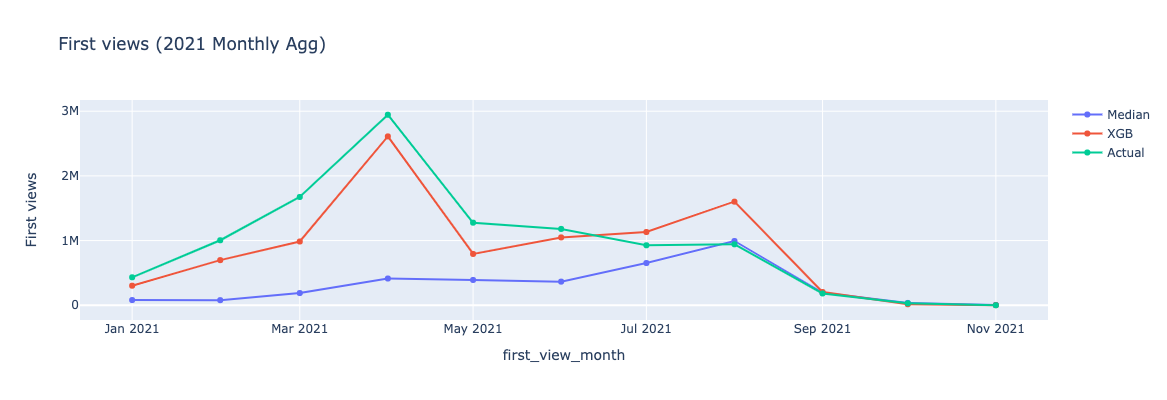

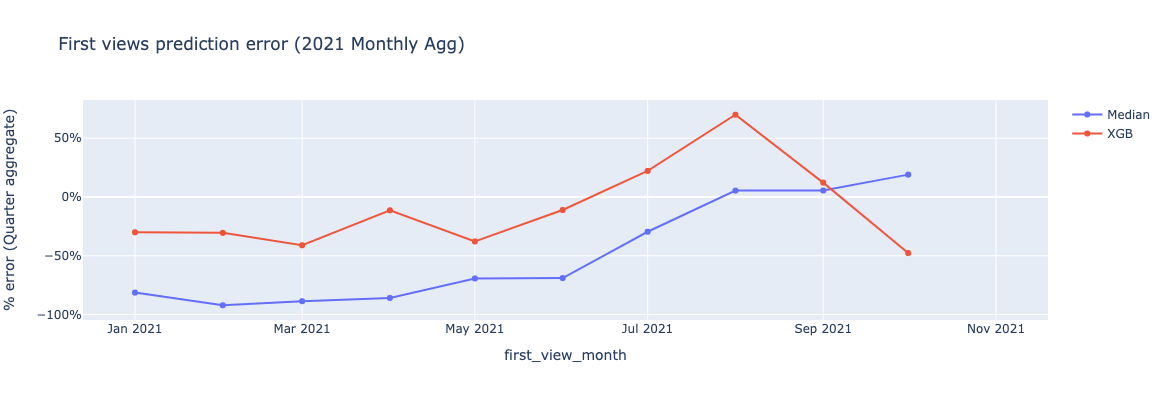

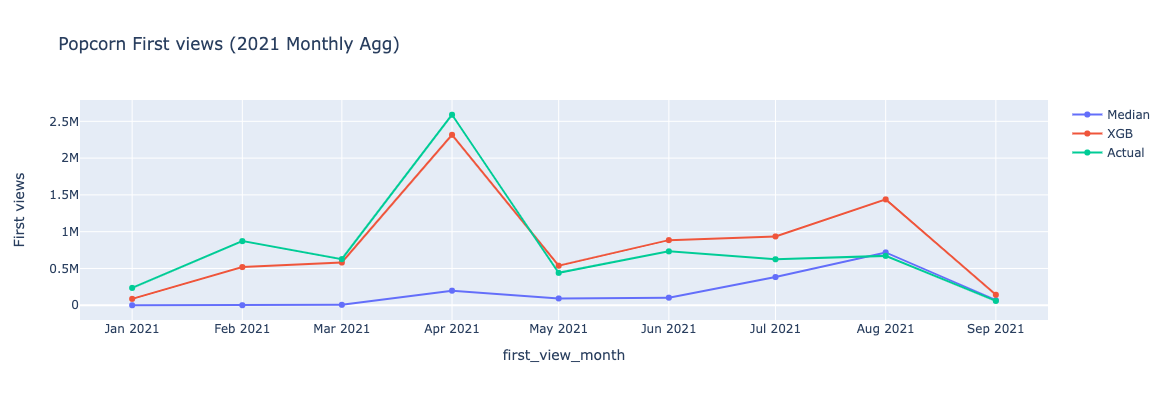

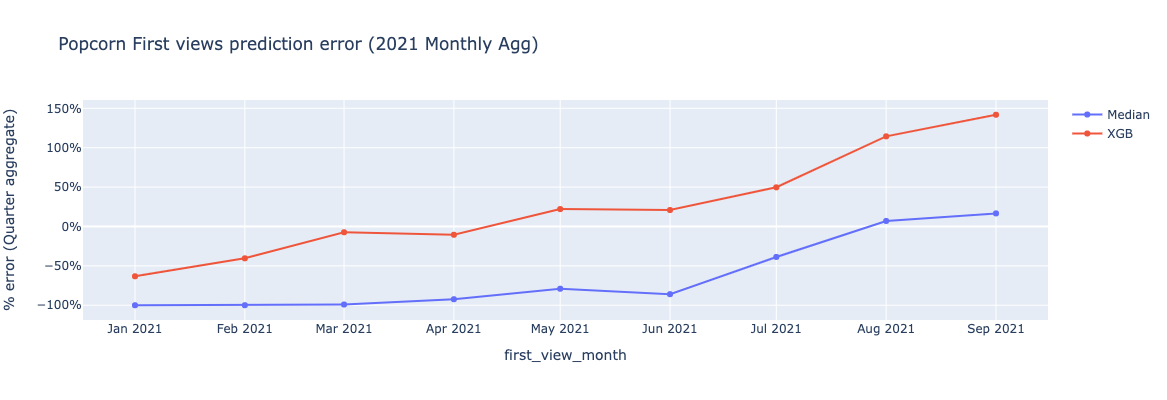

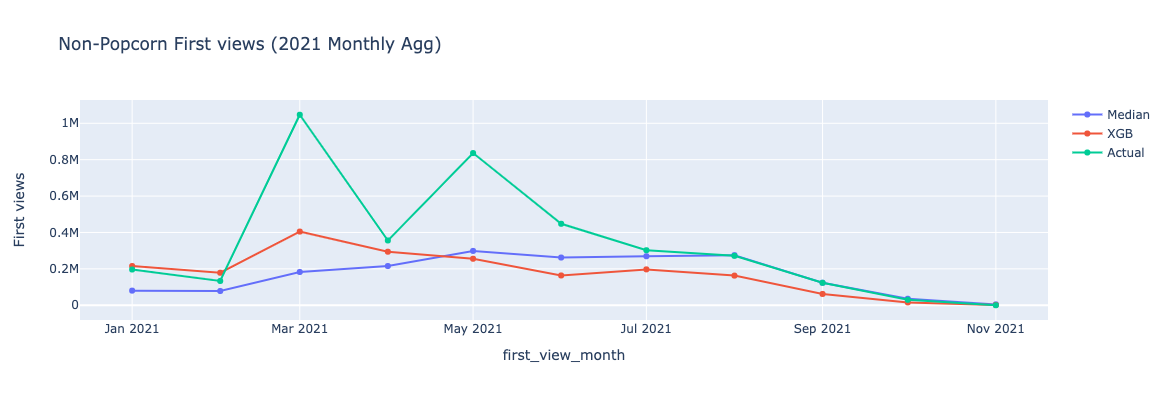

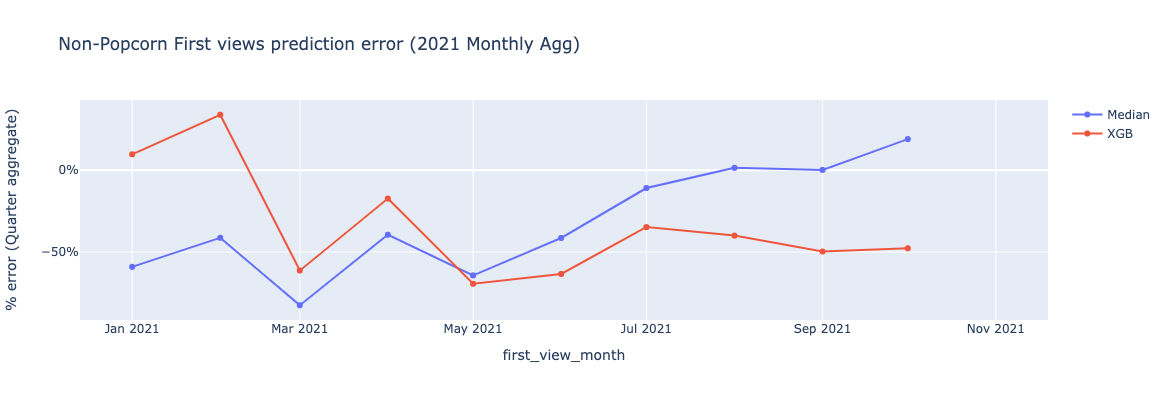

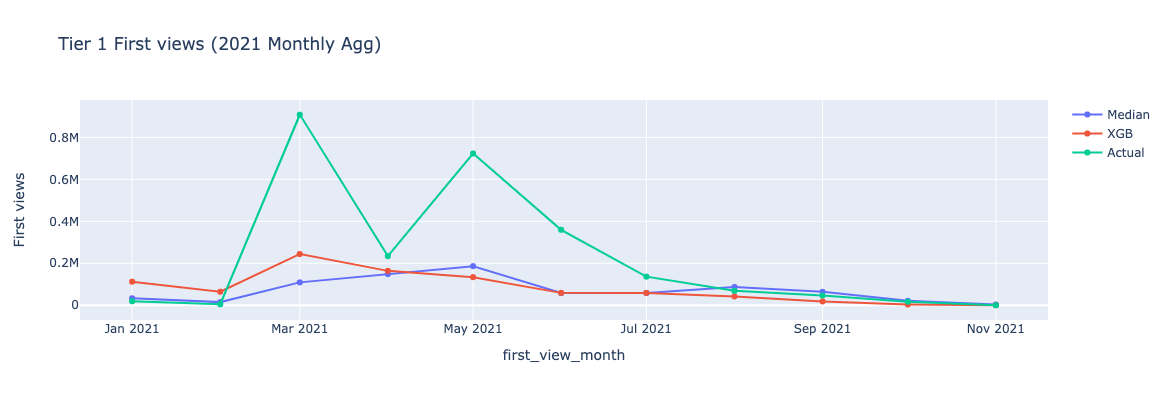

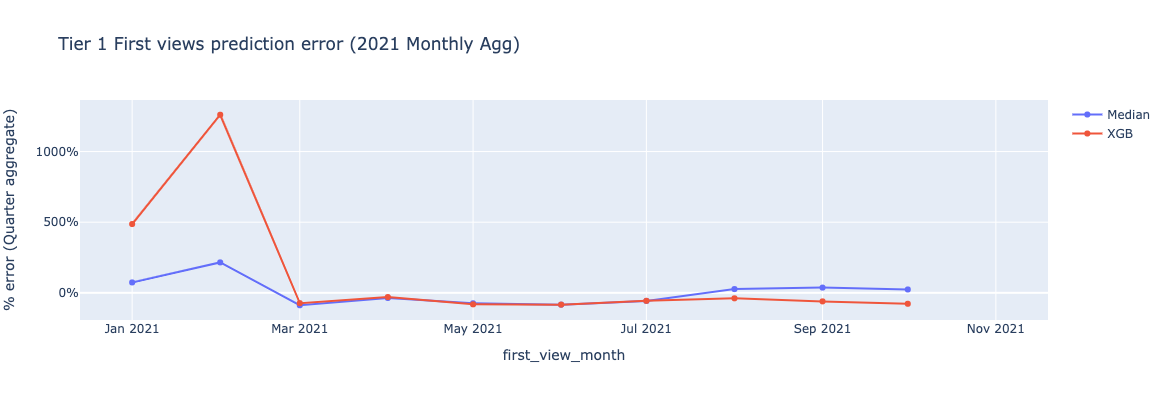

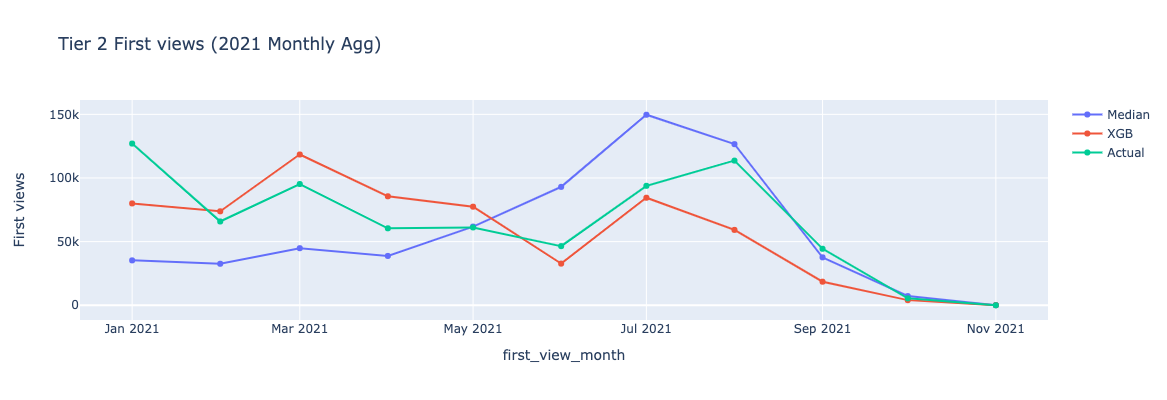

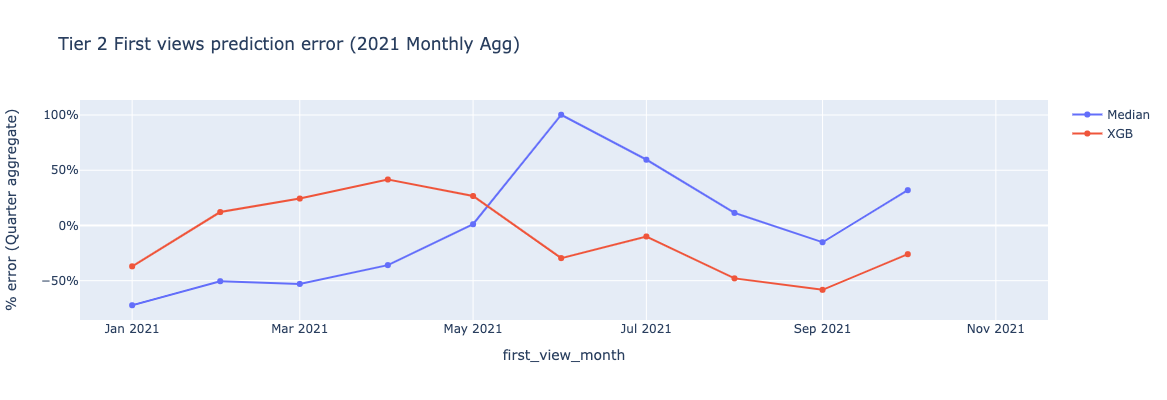

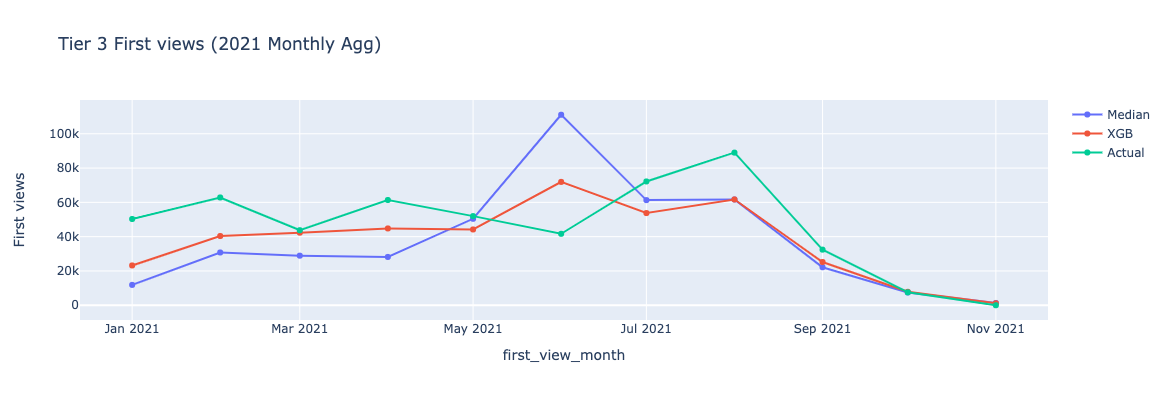

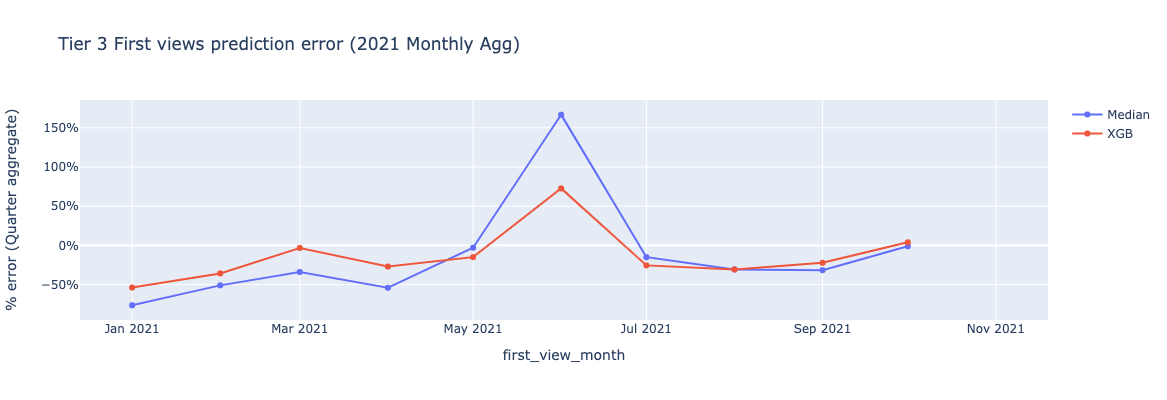

In [20]:
### Plot error 
## Month 

def evaluate_pred_plt(df_plt, grpby, var_list):
    mean_var_list = [f'mae_{i}' for i in var_list]
    sum_var_list = ['first_views'] + var_list 
    mean_dic = dict(zip(mean_var_list, ['mean'] * len(mean_var_list)))
    sum_dic = dict(zip(sum_var_list, ['sum'] * len(sum_var_list)))
    
    # Get absolute error at agg_time- title level
    df_grp = df_plt.groupby(by=grpby).agg(sum_dic).reset_index()
    for i in var_list:
        df_grp[f'mae_{i}'] = (df_grp[i] - df_grp['first_views']).abs()  ## mae is actually ae here. mean taken in the next step

    ## aggregate to agg_time level (month, quarter)
    agg_dic =  {k: v for d in (mean_dic, sum_dic) for k, v in d.items()}
    df_grp = df_grp.groupby(by=grpby[:-2]).agg(agg_dic).reset_index()
    for i in var_list:
        df_grp[f'pct_error_{i}'] = (df_grp[i] - df_grp['first_views'])/df_grp['first_views']*100

    return df_grp

def get_pred_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'first_views_decay_{i}' for i in ['median_mx', 'dev_b']] + ['first_views'] ## Variables to be plotted
            ,'title': title  ## Plot title
            ,'labellist':['Median','XGB', 'Actual'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': 'First views'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    py.offline.iplot(fig)
    
    return 

def get_pct_error_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':[f'pct_error_first_views_decay_{i}' for i in ['median_mx', 'dev_b']] ## Variables to be plotted
            ,'title':title  ## Plot title
            ,'labellist':['Median','XGB'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': '% error (Quarter aggregate)'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    fig['layout']['yaxis'].update({'ticksuffix':'%'})
    py.offline.iplot(fig)
    
    return 


list_postfix = ['dev_b']
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval, grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
display(df_grp)
get_pred_plot(df_grp, agg_var,'First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp, agg_var, 'First views prediction error (2021 Monthly Agg)')


## Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category=='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Popcorn First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp, agg_var, 'Popcorn First views prediction error (2021 Monthly Agg)')

df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])
get_pred_plot(df_grp, agg_var,'Non-Popcorn First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp, agg_var, 'Non-Popcorn First views prediction error (2021 Monthly Agg)')



## Tiers 
grpby=[agg_var,'tier', 'title_name', 'season_number'] 
df_grp=evaluate_pred_plt(df_eval[df_eval.category!='Popcorn'], grpby, [f'first_views_decay_{i}' for i in ['median_mx'] + list_postfix])


get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')

get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')

get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 First views (2021 Monthly Agg)')
get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')




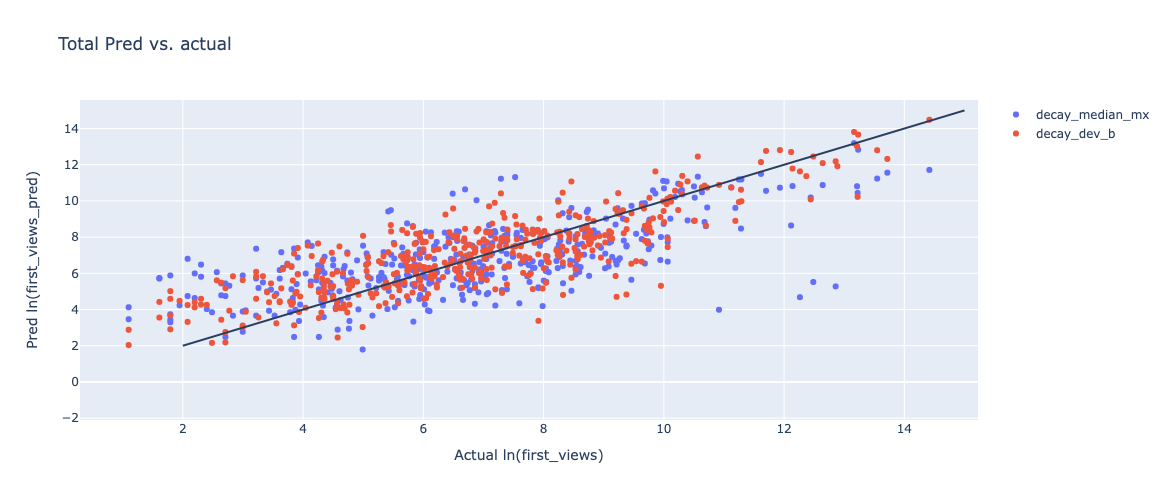

divide by zero encountered in log


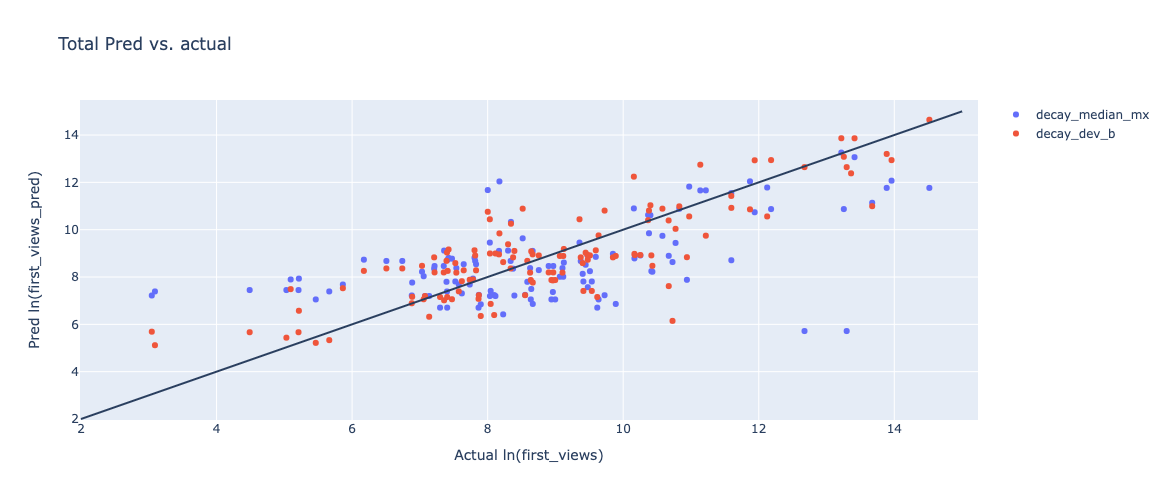


_____________________________________________________________
Aggregate actuals: Count: 125; Title-level mean: 84757;  Aggregate sum: 10594639
decay_median_mx title-level MAE: 68707; aggregate %error: -68%; pred: 3395735; 
decay_dev_b title-level MAE: 49457; aggregate %error: -11%; pred: 9393825; 


In [24]:
def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['decay_median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text= df_plt['effective_start_date'].astype(str) + " " + df_plt['title_name'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=700,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return fig

import plotly.io as pio
list_postfix = ['decay_dev_b']
fig = get_pred_actual_plot(df_eval, 'Total', list_postfix)
# pio.write_json(fig, 'total.json')


df_eval_title = df_eval.groupby(by=['title_name','season_number','effective_start_date','tier','category'])\
                        [['first_views','first_views_decay_median_mx','first_views_decay_dev_b']].sum().reset_index()
df_eval_title['first_views_log'] = np.log(df_eval_title['first_views'] )
df_eval_title['first_views_decay_median_mx_log'] = np.log(df_eval_title['first_views_decay_median_mx'])
df_eval_title['first_views_decay_dev_b_log'] = np.log(df_eval_title['first_views_decay_dev_b'])

fig = get_pred_actual_plot(df_eval_title, 'Total', list_postfix)


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')

evaluate_pred(df_eval_title, ['decay_median_mx','decay_dev_b'])

# fig =get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
# fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==1)], 'Q1', list_postfix)
# fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==2)], 'Q2', list_postfix)
# fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==3)], 'Q3', list_postfix)


# get_pred_actual_plot(df_eval[(df_eval.start_quarter==2)], 'Q2', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [30]:
print(df_raw[df_raw.start_year_month>='2021-01-01'].title_name.nunique())
df_raw.groupby(by='start_year_month').title_name.nunique()

113


start_year_month
2020-05     7
2020-06    19
2020-07    15
2020-08    28
2020-09    17
2020-10    23
2020-11    26
2020-12    20
2021-01    18
2021-02    17
2021-03    15
2021-04    17
2021-05    15
2021-06    15
2021-07    23
2021-08    15
Name: title_name, dtype: int64

In [26]:
df_raw.head()

Unnamed: 0               title_id  title_name  season_number  \
0           0  GYBMTBAxniqsjwwEAAAAR  The Bridge              1   
1           1  GYBMTBAxniqsjwwEAAAAR  The Bridge              1   
2           2  GYBMTBAxniqsjwwEAAAAR  The Bridge              1   
3           3  GYBMTBAxniqsjwwEAAAAR  The Bridge              1   
4           4  GYBMTBAxniqsjwwEAAAAR  The Bridge              1   

  content_category content_source program_type           category  tier  \
0           series        HBO Max     original  Unscripted Series     3   
1           series        HBO Max     original  Unscripted Series     3   
2           series        HBO Max     original  Unscripted Series     3   
3           series        HBO Max     original  Unscripted Series     3   
4           series        HBO Max     original  Unscripted Series     3   

  effective_start_date request_date  premiere_ind  asset_premiere_count  \
0           2021-02-11   2021-04-10             0                     0   
1           2021-02-11   2021-04-11             0                     0   
2           2021-02-11   2021-04-12             0                     0   
3           2021-02-11   2021-04-13             0                     0   
4           2021-02-11   2021-04-14             0                     0   

   premiering_hours_runtime  first_views  hours_viewed  days_since_premiere  \
0                       0.0            8       939.552                   58   
1                       0.0            7      1138.318                   59   
2                       0.0            2       836.381                   60   
3                       0.0            1       820.189                   61   
4                       0.0            4       771.214                   62   

   days_on_platform  finished_window_flag  start_year  start_month  \
0               254                     1        2021            2   
1               254                     1        2021            2   
2               254                     1        2021            2   
3               254                     1        2021            2   
4               254                     1        2021            2   

  start_year_month  start_quarter  
0          2021-02              1  
1          2021-02              1  
2          2021-02              1  
3          2021-02              1  
4          2021-02              1

In [ ]:
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_dev_log'] = np.log(df_eval['first_views_dev'])
# df_eval['first_views_median_log'] = np.log(df_eval['first_views_median'])
df_eval['first_views_median_mx_log'] = np.log(df_eval['first_views_median_mx'])
df_eval['first_views_dev_a_log'] = np.log(df_eval['first_views_dev_a'])
df_eval['first_views_dev_b_log'] = np.log(df_eval['first_views_dev_b'])
df_eval['first_views_dev_c_log'] = np.log(df_eval['first_views_dev_c'])


def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text=df_plt['start_year_month'] + " " + df_plt['title_name'].astype(str) + df_plt['start_year_month'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=500,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return 

get_pred_actual_plot(df_eval, 'Total', list_postfix)
get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.start_quarter==1)], 'Q1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.start_quarter==2)], 'Q2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [15]:
df_test[df_test.title_name.str.contains('Godzilla')]

tier content_category category         title_name               title_id  \
0     1           movies     Pay1  Godzilla vs. Kong  GYFEzmwNES16GkQEAAAAC   

   season_number program_type effective_start_date  start_year  start_month  \
0              0     acquired           2021-08-17        2021            8   

  start_year_month  start_quarter  first_views  premiering_hours_runtime  \
0          2021-08              3        68095                       0.0   

   first_views_log   asset_title_long    imdb_id  \
0        11.128659  Godzilla vs. Kong  tt5034838   

                           genres title_type  ref_follows  ref_remake_of  \
0  ["Action","Sci-Fi","Thriller"]      movie          3.0            2.0   

   ref_spin_off_from  ref_version_of  ref_ref_featured_in  ref_ref_spoofed_in  \
0                0.0             0.0                146.0                18.0   

   ref_tot  ref_ref_tot  
0      5.0        164.0

## Model diagnosis

2021-03-01 122 (1, 27)


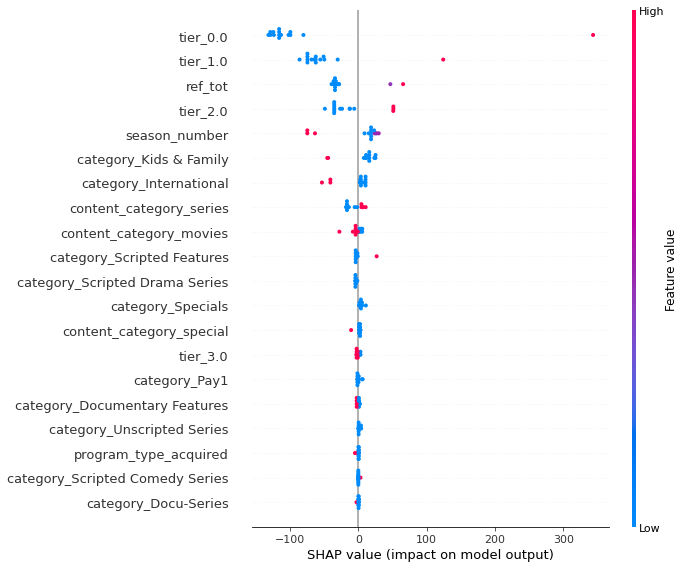

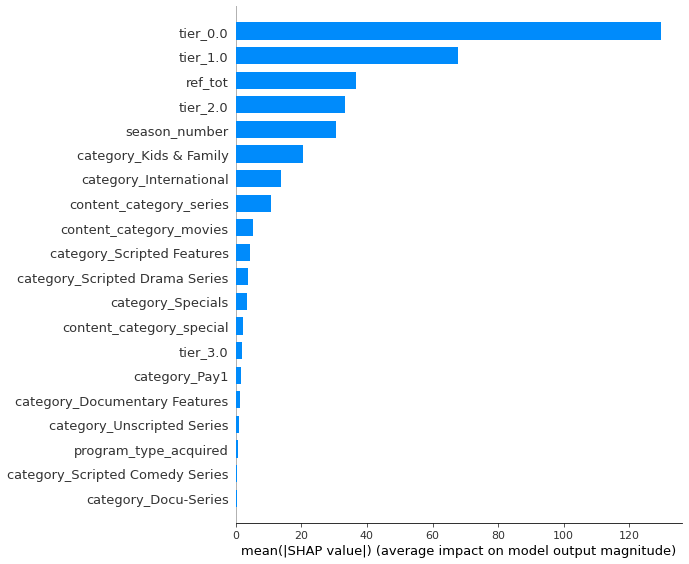

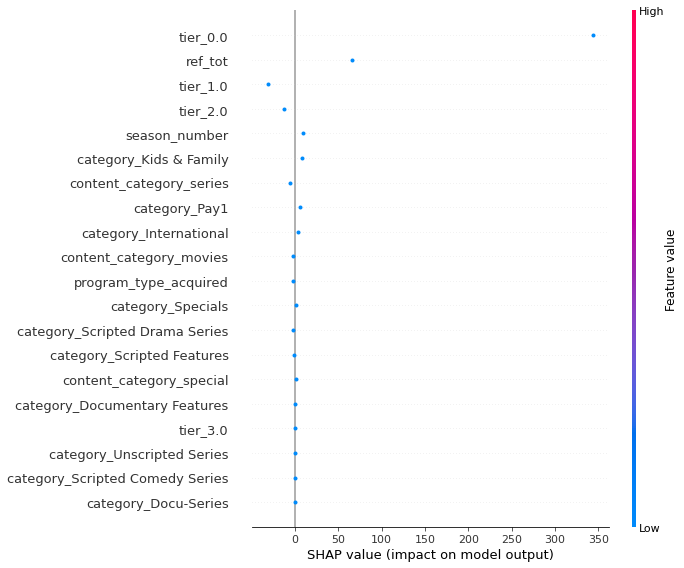

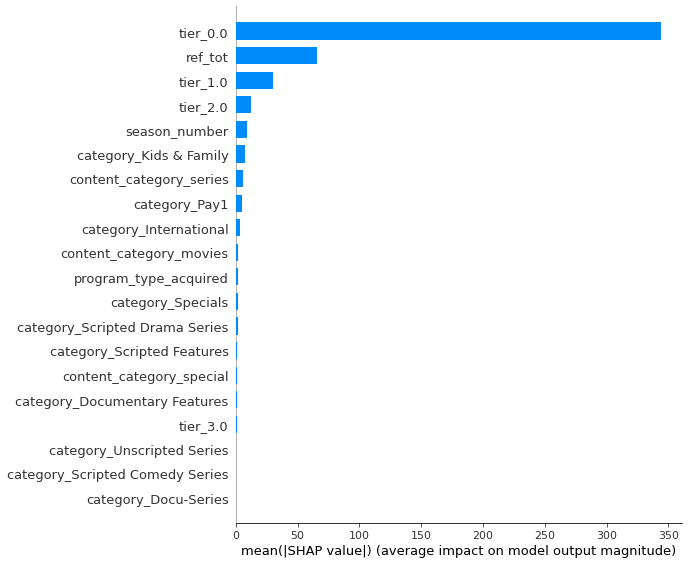

In [82]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
]


df_pred_list = []
for title, date_pred in zip(['Godzilla'],['2021-03-01']):
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
#     df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
#     df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)

2021-04-01 135 (2, 27)


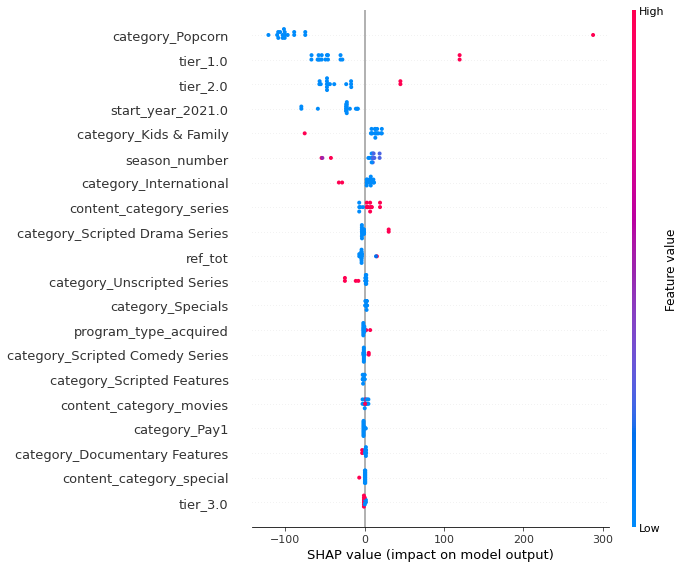

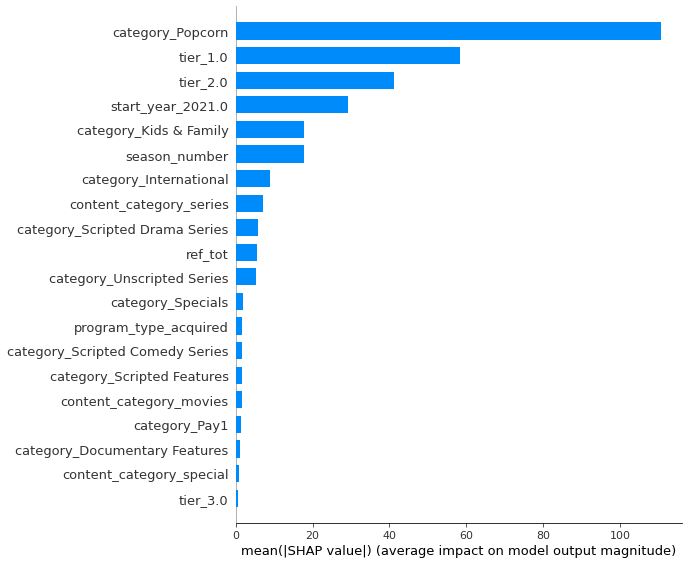

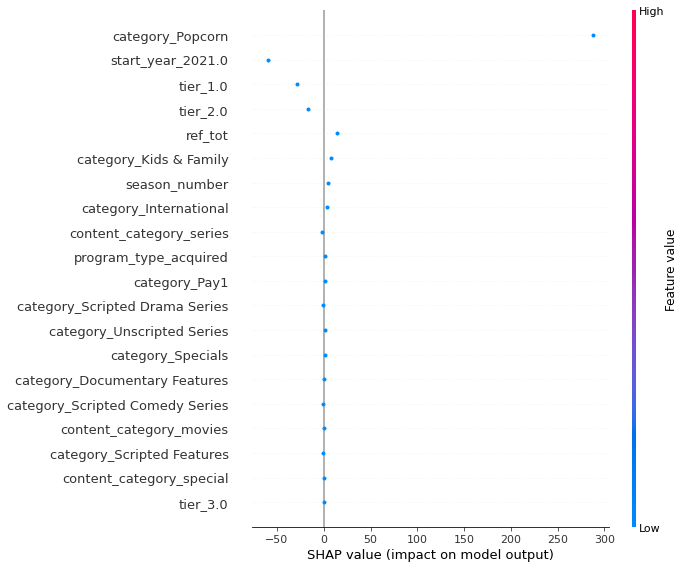

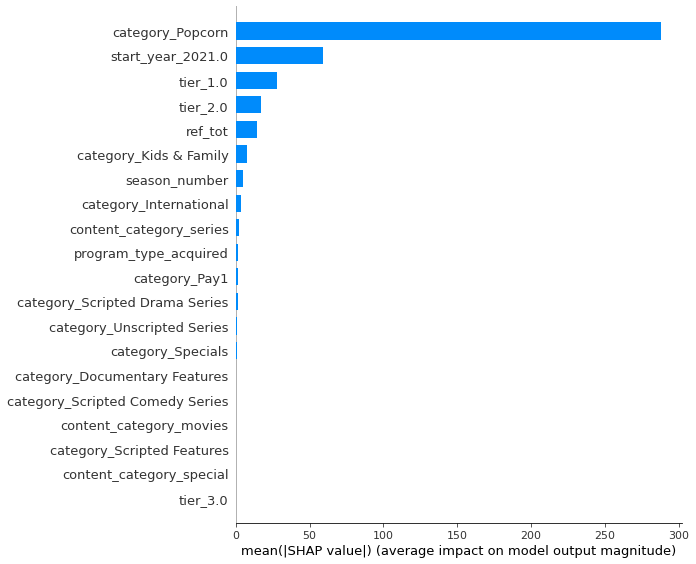

In [68]:
df_pred_list = []
for title, date_pred in zip(['Mortal'],['2021-04-01']):
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
#     df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
#     df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

    ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)
    ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains(title)], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)
# display(df_pred)